# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto
Week 3 of the Coursera: Applied Data Science Capstone https://www.coursera.org/learn/applied-data-science-capstone/home/welcome   

## Solutions

1. <a href="#item1">Create first dataframe</a>

2. <a href="#item2">Add Latitude and Longitude</a>

3. <a href="#item3">Cluster/Analysis Neighborhoods</a>


In [1]:
# importing important libraries
import numpy as np
import pandas as pd
import requests

# plot, rendering libraries
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors

# import kmean for later clustering
from sklearn.cluster import KMeans

## Obtaining neighborhoods data

In [2]:
# wikipedia scraping
url= r'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
# using pd built-in read_html to find the table and create the df, setting Not assigned as NaN
toronto_neighborhoods= pd.read_html(requests.get(url).content, na_values='Not assigned')[0]
toronto_neighborhoods[:3]

,Postcode,Borough,Neighbourhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods


### toronto_neighborhoods df cleaning

In [3]:
# drop cells without a borough
toronto_neighborhoods.dropna(subset=['Borough'], inplace= True)
# fill NaN neighborhood with borough
toronto_neighborhoods['Neighbourhood'].fillna(toronto_neighborhoods['Borough'], inplace=True)
toronto_neighborhoods[:3]

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
#checking if NaN remains in neighborhood
toronto_neighborhoods['Neighbourhood'].isnull().sum()

0

## 1. First Dataframe (point 3 of the assignment)
<a id="item1">

In [5]:
# joining Neighobourhood with same Postcode
df_group_hoods= pd.DataFrame(toronto_neighborhoods.groupby(['Postcode', 'Borough']).apply(lambda x: ', '.join(x['Neighbourhood'])))
df_group_hoods.reset_index(inplace= True) # resetting index after groupby
df_group_hoods.columns= toronto_neighborhoods.columns # renaming columns as previous df
df_group_hoods[:3]

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"


In [6]:
df_group_hoods.shape

(103, 3)

## Importing Geospatial Data

I have tried to use geocoder library, google was not responding and other services (osm and here) where not able to identify all postcode, i an going to download the cvs file

In [7]:
!wget -q -O geospatial.csv https://cocl.us/Geospatial_data
print('geospatial.csv downloaded')

geospatial.csv downloaded


In [8]:
# read the csv file
df_geospatial= pd.read_csv('geospatial.csv')
df_geospatial.columns= ['Postcode', 'Latitude', 'Longitude']
df_geospatial[:3]

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711


## Dataframe including latitude and longitude
<a href="item2">

In [9]:
df_toronto= pd.merge(df_group_hoods, df_geospatial, how= 'left',  on='Postcode')
df_toronto[:3]

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711


## Exploring Toronto's neighborhoods

In [10]:
CLIENT_ID = 'IJEGQZHUQM3MZYQNYBFYTBSP5JFIMV3XLAWHBZ1RLPUIIKW5' # your Foursquare ID
CLIENT_SECRET = 'C1SAKNBHCXE2MIG0AHO421M2EHLRQFQFXBM14DOPNLANU3RU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT= 100):
    '''Given latitude and longitude of a given place(name), use Foursquare to find the sourrounding venus. Limited at radius and total venus returned'''
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                 latitudes=df_toronto['Latitude'],
                                 longitudes=df_toronto['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West, Steeles West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The D

### checking the df obtained from Foursquare

let's check if all the neighborhood are presents

In [13]:
len(toronto_venues['Neighborhood'].unique())

100

it seems that 3 neighborhoods are missing, let's check which ones

In [14]:
no_venues_neighborhood= np.setdiff1d(df_group_hoods['Neighbourhood'],toronto_venues['Neighborhood'])
no_venues_neighborhood

array(['Islington Avenue', 'Newtonbrook, Willowdale', 'Upper Rouge'],
      dtype=object)

checking on foursquare there are not many venues in these locations, i decided to not increase the radius and leave these 3 neighborhood with None

In [15]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 272 uniques categories.


In [16]:
print(toronto_venues.shape)
toronto_venues[:3]

(2222, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place


We have 103 different postalcodes, having 2233 results means that many neigborhood groups are far from the 100 venues limit setted before

In [17]:
print('In average, there are {:.0f} venues per neighbohood group'.format(toronto_venues.shape[0]/df_toronto.shape[0]))

In average, there are 22 venues per neighbohood group


Checking how the venues are distributed

In [18]:
venues_neighborhood= toronto_venues.groupby('Neighborhood').count().sort_values(by='Venue', ascending= True)

In [19]:
venues_neighborhood[:5]

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park",1,1,1,1,1,1
Weston,1,1,1,1,1,1
"Silver Hills, York Mills",1,1,1,1,1,1
Scarborough Village,1,1,1,1,1,1
"Rouge, Malvern",1,1,1,1,1,1


In [20]:
venues_neighborhood[-5:]

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"First Canadian Place, Underground city",100,100,100,100,100,100
"Design Exchange, Toronto Dominion Centre",100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
St. James Town,100,100,100,100,100,100
"Harbourfront East, Toronto Islands, Union Station",100,100,100,100,100,100


There are neighborhood with only one venue, we will check how they are distributed

/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Toronto Neighborhood Venues Distribution')

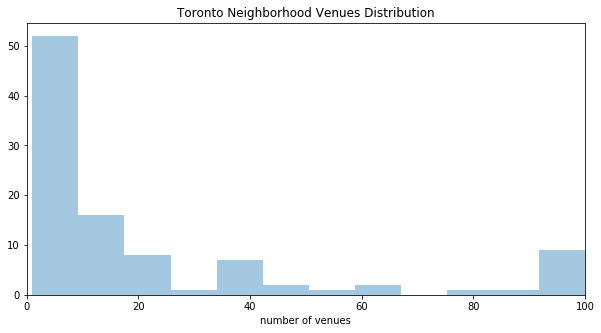

In [21]:
plt.figure(figsize= (10,5))
sns.distplot(venues_neighborhood['Venue'], kde= False)
plt.xlim(0,100)
plt.xlabel('number of venues')
plt.title('Toronto Neighborhood Venues Distribution')

From the histogram is visible that the majority of the neighborhoods have less than 20 venues

## Neighborhood Anlysis and Clustering
<a href="item3">

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot[:5]

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


now let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [23]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(toronto_grouped.shape) # checking the new shape
toronto_grouped[:5]

(100, 272)


,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00


I will now add back the Neighborhoods with no venues, setting their mean occurency value to 0

In [24]:
a= np.zeros(shape=(no_venues_neighborhood.shape[0], toronto_grouped.shape[1]))
no_venues_df= pd.DataFrame(data=a, columns= toronto_grouped.columns)
for i in range(len(no_venues_df.index)):
    no_venues_df['Neighborhood'][i] = no_venues_neighborhood[i]

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


I will now create a df with the most common venues per neighborhood

In [25]:
toronto_grouped= toronto_grouped.append(no_venues_df)

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [77]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Bar,Steakhouse,Hotel,American Restaurant,Cosmetics Shop,Asian Restaurant,Bakery
1,Agincourt,Lounge,Clothing Store,Skating Rink,Breakfast Spot,Eastern European Restaurant,Dumpling Restaurant,Electronics Store,Drugstore,Department Store,Donut Shop
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Coffee Shop,Pharmacy,Pizza Place,Beer Store,Fried Chicken Joint,Sandwich Place,Fast Food Restaurant,Women's Store,Discount Store
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Pool,Gym,Skating Rink,Pub,Pharmacy,Sandwich Place,Dance Studio,Deli / Bodega


In [78]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 6, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [79]:
# converintg UK eng in American eng to be able to merge df
df_toronto.rename(columns={'Neighbourhood': 'Neighborhood'},inplace= True )

add the labels to the df

In [80]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,6,Fast Food Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,7,Bar,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Women's Store,Event Space
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Electronics Store,Rental Car Location,Mexican Restaurant,Pizza Place,Breakfast Spot,Medical Center,Discount Store,Dessert Shop,Dim Sum Restaurant,Diner
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Athletics & Sports,Caribbean Restaurant,Bakery,Bank,Thai Restaurant,Fried Chicken Joint,Hakka Restaurant,Dumpling Restaurant,Drugstore,Donut Shop


In [81]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now checking the most occurrent clusters

Text(0.5, 0, 'Cluster')

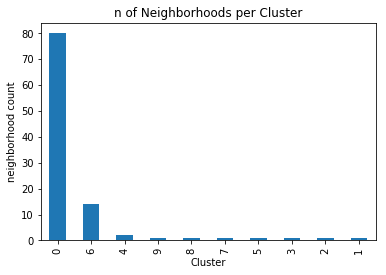

In [83]:
toronto_merged['Cluster Labels'].value_counts().plot(kind= 'bar')
plt.title('n of Neighborhoods per Cluster')
plt.ylabel('neighborhood count')
plt.xlabel('Cluster')

Checking the 2 most frequent clusters

In [68]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]][:10]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,0,Park,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant
23,North York,0,Park,Bank,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Event Space
25,North York,0,Park,Fast Food Restaurant,Food & Drink Shop,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
30,North York,0,Park,Airport,Construction & Landscaping,Bus Stop,Electronics Store,Eastern European Restaurant,Empanada Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
31,North York,0,Grocery Store,Bank,Park,Gourmet Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
40,East York,0,Park,Convenience Store,Coffee Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
44,Central Toronto,0,Park,Bus Line,Swim School,Dim Sum Restaurant,Dive Bar,Dessert Shop,Diner,Discount Store,Dog Run,Deli / Bodega
50,Downtown Toronto,0,Park,Trail,Playground,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
64,Central Toronto,0,Trail,Park,Sushi Restaurant,Jewelry Store,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
74,York,0,Park,Fast Food Restaurant,Pharmacy,Market,Women's Store,Gift Shop,German Restaurant,Drugstore,Donut Shop,Golf Course


In [84]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]][:10]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,6,Fast Food Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop
14,Scarborough,6,Park,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant
23,North York,6,Park,Bank,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Event Space
25,North York,6,Park,Fast Food Restaurant,Food & Drink Shop,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
30,North York,6,Park,Airport,Construction & Landscaping,Bus Stop,Electronics Store,Eastern European Restaurant,Empanada Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
31,North York,6,Grocery Store,Bank,Park,Gourmet Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
40,East York,6,Park,Convenience Store,Coffee Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
44,Central Toronto,6,Park,Bus Line,Swim School,Dim Sum Restaurant,Dive Bar,Dessert Shop,Diner,Discount Store,Dog Run,Deli / Bodega
50,Downtown Toronto,6,Park,Trail,Playground,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
64,Central Toronto,6,Trail,Park,Sushi Restaurant,Jewelry Store,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
